In [89]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from itertools import repeat
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
import xgboost as xgb
#import lasio
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import f1_score, make_scorer
from os import listdir
from matplotlib_venn import venn2, venn3
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
%matplotlib inline

In [2]:
np.set_printoptions(precision=3, suppress=True)

In [3]:
def conv(s):
    if s == '':
        return np.nan
    return float(s.replace(',', '.'))

columns_to_conv = ['Нефть, т', 'Конденсат, т', 'Приемистость, м3/сут', 'Обводненность (вес), %', 'Нефть, м3', 'Жидкость, м3', \
                    'Дебит конденсата', 'Добыча растворенного газа, м3', 'Дебит попутного газа, м3/сут']
convertors = dict(zip(columns_to_conv, repeat(conv.__call__, len(columns_to_conv))))

def conv_date(x):
    if x.day != 1:
        return (x + pd.offsets.MonthBegin(1))
    else:
        return x

### Загружаем данные

In [45]:
df_train = pd.read_csv('init/1/train_1.8.csv', header = 0 ,encoding = 'cp1251', parse_dates = ['Дата'], converters= convertors)
df_test = pd.read_csv('init/1/test_1.9.csv', header = 0 ,encoding = 'cp1251', parse_dates = ['Дата'], converters= convertors)

df_coord_train = pd.read_csv('init/1/coords_train_1.1.csv', header = 0,encoding = 'cp1251')
df_coord_test = pd.read_csv('init/1/coords_test_1.1.csv', header = 0,encoding = 'cp1251')
df_coord_train = df_coord_train.rename(columns={'well_hash' : 'Скважина'})
df_coord_test = df_coord_test.rename(columns={'well_hash' : 'Скважина'})
df_coord_train_gr = df_coord_train.groupby('Скважина').mean().reset_index()
df_coord_test_gr = df_coord_test.groupby('Скважина').mean().reset_index()

df_frac_train = pd.read_csv('init/1/frac_train_1.csv', header = 0,encoding = 'cp1251')
df_frac_test = pd.read_csv('init/1/frac_test_1.csv', header = 0,encoding = 'cp1251')

df_gdis_train = pd.read_csv('init/1/gdis_train1.2.csv', header = 0,encoding = 'cp1251')
df_gdis_test = pd.read_csv('init/1/gdis_test1.2.csv', header = 0,encoding = 'cp1251')
df_gdis_train_gr = df_gdis_train.groupby('Скважина').mean().reset_index()
df_gdis_test_gr = df_gdis_test.groupby('Скважина').mean().reset_index()

In [46]:
df_all_train = pd.read_csv('./out/train_formated.csv', dtype={'frac':'int8'})
df_all_test = pd.read_csv('./out/test_formatted.csv', dtype={'frac':'int8'})

### Центруем координаты (может и не надо)

In [47]:
df_coord_train['x'] = df_coord_train['ПЛАСТ_X'].astype(dtype='int32')
df_coord_train['y'] = df_coord_train['ПЛАСТ_Y'].astype(dtype='int32')
df_coord_train['x'] = df_coord_train['x'] - df_coord_train['x'].mean()
df_coord_train['y'] = df_coord_train['y'] - df_coord_train['y'].mean()

df_coord_train['x_head'] = df_coord_train['УСТЬЕ_X'].astype(dtype='int32')
df_coord_train['y_head'] = df_coord_train['УСТЬЕ_Y'].astype(dtype='int32')
df_coord_train['x_head'] = df_coord_train['x_head'] - df_coord_train['x_head'].mean()
df_coord_train['x_head'] = df_coord_train['x_head'] - df_coord_train['x_head'].mean()

<IPython.core.display.Javascript object>


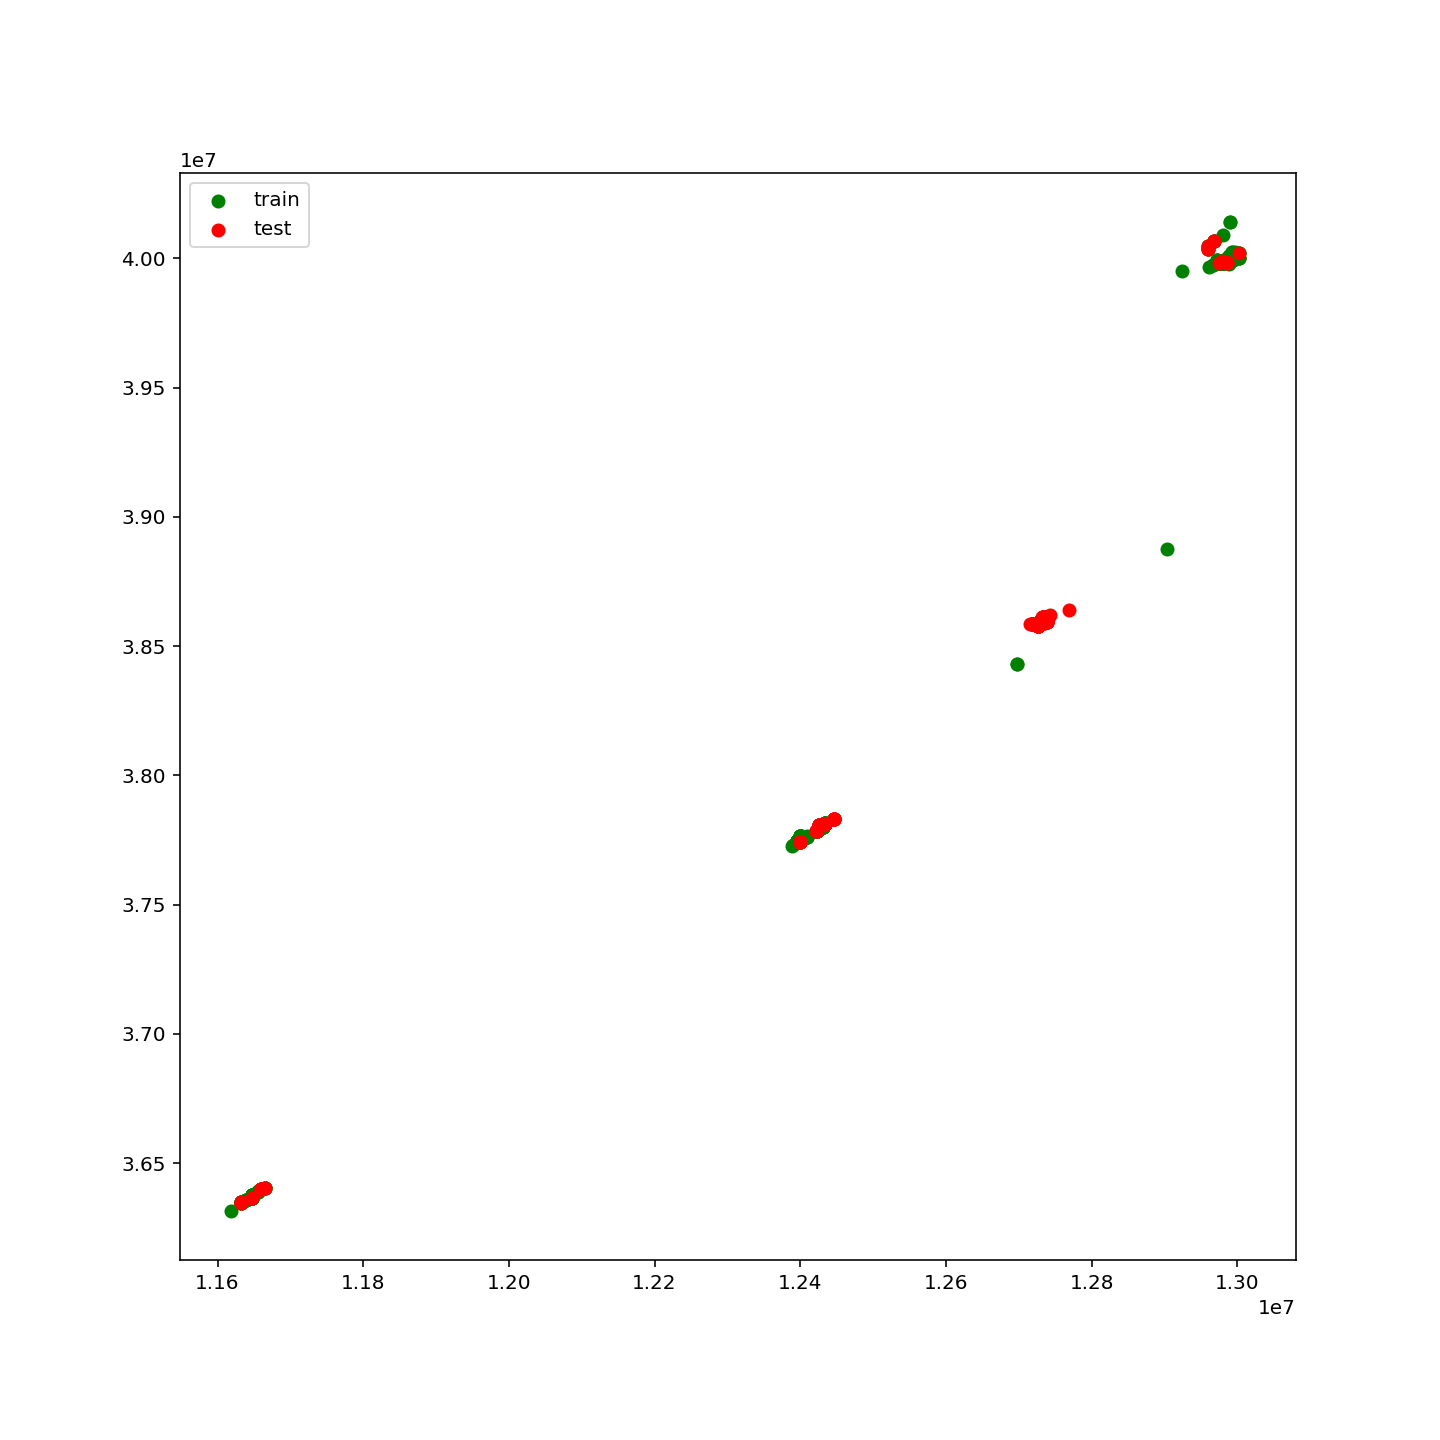

In [48]:
%matplotlib notebook
plt.figure(figsize=(10,10))
plt.scatter(df_coord_train.drop_duplicates('Скважина', 'first')['ПЛАСТ_X'], 
            df_coord_train.drop_duplicates('Скважина', 'first')['ПЛАСТ_Y'], color = 'g', label='train')
plt.scatter(df_coord_test.drop_duplicates('Скважина', 'first')['ПЛАСТ_X'], 
            df_coord_test.drop_duplicates('Скважина', 'first')['ПЛАСТ_Y'], color = 'r', label='test')
plt.legend()

In [49]:
w_coord_train = df_coord_train['Скважина'].unique()
w_coord_test = df_coord_test['Скважина'].unique()
w_train = df_train['Скважина'].unique()
w_test = df_test['Скважина'].unique()
w_frac_train = df_frac_train['Скважина'].unique()
w_frac_test = df_frac_test['Скважина'].unique()
w_gdis_train = df_gdis_train['Скважина'].unique()
w_gdis_test = df_gdis_test['Скважина'].unique()
#las_files_train = list(map(lambda x: x[:-4], listdir('init/1/las_train2/')))
#las_files_test = list(map(lambda x: x[:-4], listdir('init/1/las_test2/')))

### Рассчитаем нужные свойства и объединим стобцы

In [50]:
df_train.loc[:, 'Дата'] = df_train['Дата'].apply(conv_date)

df_train['days_on'] = df_train['Время работы, ч']/24

df_train['oil_rate'] = df_train['Нефть, м3']/(df_train['Время работы, ч']/24)

df_train['oil_prod'] = df_train['Нефть, т']

df_train['liq_rate'] = df_train['Жидкость, м3']/(df_train['Время работы, ч']/24)

df_train.loc[df_train['liq_rate'].isnull(), 'liq_rate'] = df_train[df_train['liq_rate'].isnull()]['Дебит жидкости']

df_train.loc[df_train['oil_rate'].isnull(), 'oil_rate'] = df_train[df_train['oil_rate'].isnull()]['liq_rate'] \
                                                            *(1-df_train[df_train['oil_rate'].isnull()]['Обводненность']/100)

df_train['wct'] = 1 - df_train['Нефть, м3']/df_train['Жидкость, м3']
df_train.loc[df_train['wct'].isnull(), 'wct'] = df_train.loc[df_train['wct'].isnull(), 'Обводненность']/100

df_train['gas_rate'] = df_train['Попутный газ, м3']/(df_train['Время работы, ч']/24)
df_train.loc[df_train['gas_rate'].isnull(), 'gas_rate'] = df_train[df_train['gas_rate'].isnull()]['Газовый фактор']* \
                                                           df_train[df_train['gas_rate'].isnull()]['oil_rate'] 

df_train['gas_prod'] = df_train['Попутный газ, м3']

df_train['gf'] = df_train['Попутный газ, м3']/df_train['Нефть, т']
df_train.loc[df_train['gf'].isnull(), 'gf'] = df_train[df_train['gf'].isnull()]['Газовый фактор']

df_train['state'] = df_train['Состояние']
df_train.loc[df_train['state'].isnull(), 'state'] = df_train.loc[df_train['state'].isnull(), 'Состояние на конец месяца'] 

df_train['frac'] = df_train['Скважина'].apply(lambda x: x in df_frac_train['Скважина'].values).astype(int)

#### Средняя плотность нефти

In [51]:
oil_dens_mean = df_train[df_train['Скважина'].isin(df_train['Скважина'].unique())]['Плотность нефти'].mean()

In [52]:
df_test.loc[:, 'Дата'] = df_test['Дата'].apply(conv_date)

df_test['days_on'] = df_test['Время работы, ч']/24

#df_test['oil_rate'] = df_test['Нефть, м3']/(df_test['Время работы, ч']/24)

#df_test['oil_prod'] = df_test['Нефть, т']

#df_test['liq_rate'] = df_test['Жидкость, м3']/(df_test['Время работы, ч']/24)

#df_test.loc[df_test['liq_rate'].isnull(), 'liq_rate'] = df_test[df_test['liq_rate'].isnull()]['Дебит жидкости']

#df_test.loc[df_test['oil_rate'].isnull(), 'oil_rate'] = df_test[df_test['oil_rate'].isnull()]['liq_rate'] \
#                                                            *(1-df_test[df_test['oil_rate'].isnull()]['Обводненность']/100)

df_test['wct'] = df_test['Обводненность (вес), %']/100
df_test.loc[df_test['wct'].isnull(), 'wct'] = df_test.loc[df_test['wct'].isnull(), 'Обводненность']/100

df_test['gas_rate'] = df_test['Попутный газ, м3']/df_test['days_on'] 
#df_test.loc[df_test['gas_rate'].isnull(), 'gas_rate'] = df_test[df_test['gas_rate'].isnull()]['Газовый фактор']* \
#                                                           df_test[df_test['gas_rate'].isnull()]['oil_rate'] 

df_test['gas_prod'] = df_test['Попутный газ, м3']



#df_test['gf'] = df_test['Попутный газ, м3']/df_test['Нефть, т']
#df_test.loc[df_test['gf'].isnull(), 'gf'] = df_test[df_test['gf'].isnull()]['Газовый фактор']

#df_test['state'] = df_test['Состояние']
#df_test.loc[df_test['state'].isnull(), 'state'] = df_test.loc[df_test['state'].isnull(), 'Состояние на конец месяца'] 

df_test['frac'] = df_test['Скважина'].apply(lambda x: x in df_frac_test['Скважина'].values).astype(int)

#### Данные для стартового месяца только

In [53]:
df_all_train_0 = df_all_train[df_all_train['month'] == 0]

### Выделяем "левые" скважины (*_bd1)

In [54]:
#wells_test = df_test['Скважина'].tolist()
wells_bd1_test = df_test[~df_test['Обводненность (вес), %'].isnull()]['Скважина'].tolist()
wells_bd1_test_0 = df_all_test[df_all_test['days_on'] == 0]['Скважина'].tolist()
wells_bd1_test = list(set(wells_bd1_test) - set(wells_bd1_test_0))

wells_bd2_test = df_test[~df_test['Обводненность'].isnull()]['Скважина'].tolist()

<IPython.core.display.Javascript object>


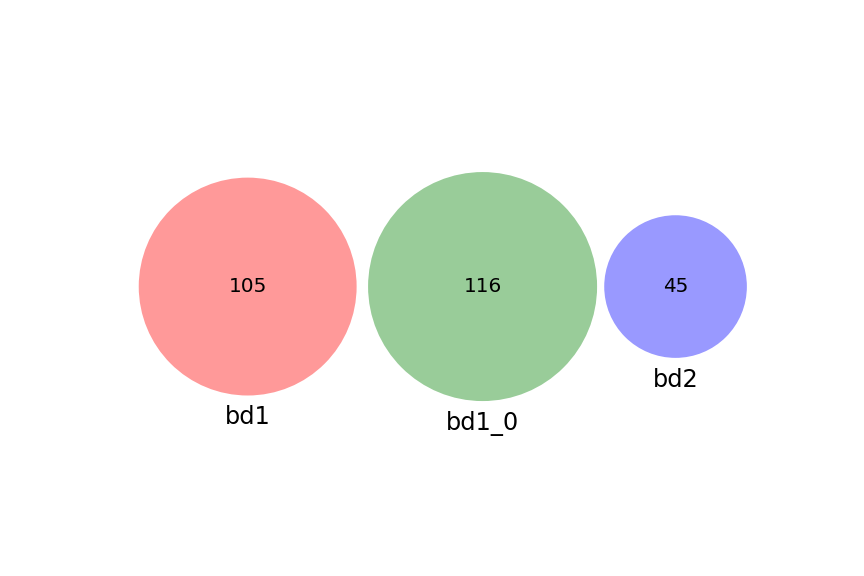

True


In [55]:
venn3(subsets = [set(wells_bd1_test), set(wells_bd1_test_0), set(wells_bd2_test)],
     set_labels = ['bd1', 'bd1_0', 'bd2'])
print(len(wells_bd1_test) + len(wells_bd1_test_0) + len(wells_bd2_test) == len(w_test))

In [56]:
wells_bd1_train = df_train[~df_train['Обводненность (вес), %'].isnull()]['Скважина'].unique().tolist()
wells_bd2_train = df_train[~df_train['Обводненность'].isnull()]['Скважина'].unique().tolist()
wells_bd2_train = list(set(wells_bd2_train) & set(df_all_train_0['Скважина'].tolist()))
wells_bd1_train = list(set(wells_bd1_train) & set(df_all_train_0['Скважина'].tolist()))

/Users/aramdavtyan/datascience-env/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


<IPython.core.display.Javascript object>


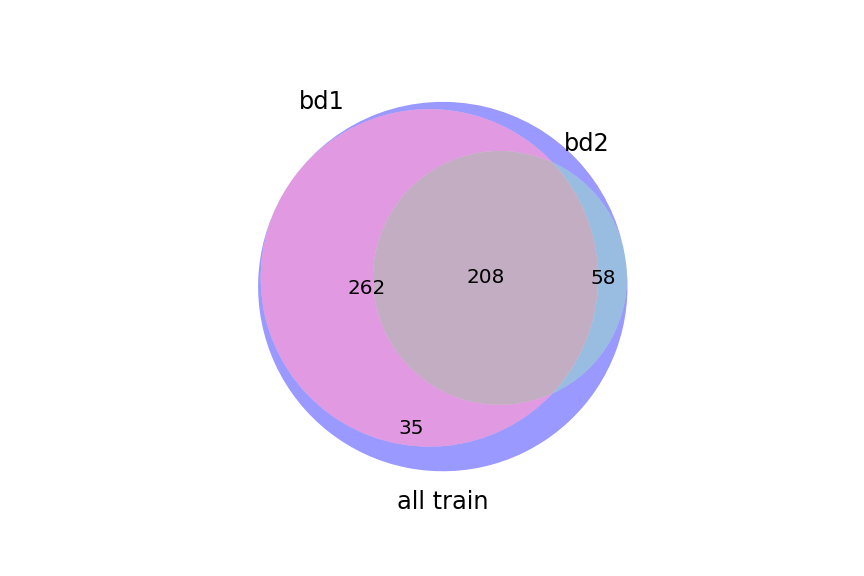

False


In [57]:
venn3(subsets = [set(wells_bd1_train), set(wells_bd2_train), set(w_train)],
     set_labels = ['bd1', 'bd2', 'all train'])
print(len(wells_bd1_train) + len(wells_bd2_train)  == len(w_train))

### Выделяем данные левых скважин в отдельные df

In [58]:
df_train_bd1 = df_all_train_0[(df_all_train_0['Скважина'].isin(wells_bd1_train))  & (df_all_train_0['days_on'] > 0)]

df_train_bd1.loc[:, 'Давление пластовое'] = df_train_bd1['Давление пластовое'].fillna(df_train_bd1['Давление пластовое'].mean())

df_train_bd1.loc[:, 'wct'] = df_train_bd1['wct'].fillna(0.0)

df_train_bd1.loc[:, 'frac'] = df_train_bd1['frac'].astype('int8')

/Users/aramdavtyan/datascience-env/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [59]:
df_test_bd1 = df_all_test[(df_all_test['Скважина'].isin(wells_bd1_test))]
df_test_bd1.loc[df_test_bd1['Давление пластовое'] ==0, 'Давление пластовое'] = df_test_bd1[df_test_bd1['Давление пластовое'] !=0].mean()
df_test_bd1.loc[:, 'Давление пластовое'] = df_test_bd1['Давление пластовое'].fillna(df_test_bd1['Давление пластовое'].mean())
df_test_bd1.loc[:, 'wct'] = df_test_bd1['wct'].fillna(0.0)
df_test_bd1.loc[:, 'frac'] = df_test_bd1['frac'].astype('int8')

/Users/aramdavtyan/datascience-env/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Готовим данные для модели координатного кластера 

In [60]:
df_frac_train = df_frac_train.fillna(df_frac_train.median()).drop('Проппант', 1)
df_frac_test = df_frac_test.fillna(df_frac_test.median()).drop('Проппант', 1)

In [61]:
df_train_bd1 = pd.merge(df_train_bd1, df_frac_train, on='Скважина')
df_test_bd1 = pd.merge(df_test_bd1, df_frac_test, on='Скважина')

In [62]:
X_clust = df_train_bd1[(~df_train_bd1['clust'].isnull())]. \
                dropna(subset = ['wct', 'gas_rate', 'frac'])[['wct', 'gas_rate', 'frac']]
y_clust = df_train_bd1[(~df_train_bd1['clust'].isnull())]. \
            dropna(subset = ['wct', 'gas_rate', 'frac'])['clust']
X_clust_test = df_train_bd1[(df_train_bd1['clust'].isnull())].\
                dropna(subset = ['wct', 'gas_rate', 'frac'])[['wct', 'gas_rate', 'frac']]


In [63]:
X_clust_t = df_test_bd1[~df_test_bd1['clust'].isnull()]. \
            dropna(subset = ['wct', 'gas_rate', 'frac'])[['wct', 'gas_rate', 'frac']]
y_clust_t = df_test_bd1[~df_test_bd1['clust'].isnull()].dropna(subset = ['wct', 'gas_rate', 'frac'])['clust']
X_clust_t_test = df_test_bd1[df_test_bd1['clust'].isnull()]. \
                dropna(subset = ['wct', 'gas_rate', 'frac'])[['wct', 'gas_rate', 'frac']]

### кросс вал модели кластера

In [65]:
clust_bd1 = GradientBoostingClassifier(n_estimators=300, learning_rate=0.01, max_depth=6)
#clust_cat_bd1 = CatBoostClassifier()
cross_validate(clust_bd1, pd.concat((X_clust, X_clust_t), axis = 0), pd.concat((y_clust, y_clust_t), axis = 0), scoring=make_scorer(f1_score, average='macro'))

{'fit_time': array([1.255, 1.218, 1.175]),
 'score_time': array([0.003, 0.003, 0.004]),
 'test_score': array([0.421, 0.432, 0.237]),
 'train_score': array([1.   , 0.993, 0.993])}

In [66]:
clust_bd1.fit(pd.concat((X_clust, X_clust_t), axis = 0) , pd.concat((y_clust, y_clust_t), axis = 0))
y_clust_test = clust_bd1.predict(X_clust_test)
y_clust_t_test = clust_bd1.predict(X_clust_t_test)

In [67]:
df_train_bd1.loc[df_train_bd1['clust'].isnull(), 'clust'] = y_clust_test
df_train_bd1.loc[:, 'clust'] = df_train_bd1['clust'].astype('int8')

In [68]:
df_test_bd1.loc[df_test_bd1['clust'].isnull(), 'clust'] = y_clust_t_test
df_test_bd1.loc[:, 'clust'] = df_test_bd1['clust'].astype('int8')

### Данные для модели стартовой добычи нефти

In [69]:
df_train_bd1.columns

Index(['Скважина', 'Дата', 'liq_rate', 'oil_rate', 'wct', 'gas_rate', 'gf',
       'gas_prod', 'days_on', 'oil_prod', 'frac', 'month',
       'Давление пластовое', 'ПЛАСТ_X', 'ПЛАСТ_Y', 'clust', 'num_of_pr',
       'num_of_plast', 'Наклон', 'Азимут', 'k', 'Ноб', 'Нэф', 'Pпл', 'Верх',
       'Низ', 'Xf', 'Hf', 'Wf', 'JD', 'FCD', 'М пр', 'Рпл Хорнер', 'Эфф',
       'Конц', 'Гель', 'М бр', 'V под', 'V гель'],
      dtype='object')

In [70]:
X_bd1 = df_train_bd1[['wct', 'gas_prod', 'days_on', 'Давление пластовое', 'clust', 'Наклон', 'Азимут', 'k', 'Ноб', 'Нэф', 'Pпл', 'Верх',
       'Низ', 'Xf', 'Hf', 'Wf', 'JD', 'FCD', 'М пр', 'Рпл Хорнер', 'Эфф',
       'Конц', 'Гель', 'М бр', 'V под', 'V гель']].dropna()
y_bd1 = df_train_bd1['oil_prod'].dropna()
X_bd1_test = df_test_bd1[['wct', 'gas_prod', 'days_on', 'Давление пластовое', 'clust', 'Наклон', 'Азимут', 'k', 'Ноб', 'Нэф', 'Pпл', 'Верх',
       'Низ', 'Xf', 'Hf', 'Wf', 'JD', 'FCD', 'М пр', 'Рпл Хорнер', 'Эфф',
       'Конц', 'Гель', 'М бр', 'V под', 'V гель']].dropna()
#X_bd_test = df_train_bd1[df_train_bd1['Давление пластовое'].isnull()][['wct', 'gas_rate']].values
#scaler = MinMaxScaler()
#X_pr = scaler.fit_transform(X_pr)

In [71]:
categorical_features_indices = np.where(X_bd1.dtypes != np.float)[0]

### Не использовалв итоге нормирование

In [72]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
x_scaler.fit(pd.concat((X_bd1[['wct', 'gas_prod', 'days_on', 'Давление пластовое']], 
                        X_bd1_test[['wct', 'gas_prod', 'days_on', 'Давление пластовое']]), 
                       axis=0))
X_bd1_scaled = np.concatenate((x_scaler.transform(X_bd1[['wct', 'gas_prod', 'days_on', 'Давление пластовое']]),
                               X_bd1['clust'].values.reshape(-1,1)),
                              axis = 1)
X_bd1_test_scaled = np.concatenate((x_scaler.transform(X_bd1_test[['wct', 'gas_prod', 'days_on', 'Давление пластовое']]),
                               X_bd1_test['clust'].values.reshape(-1,1)),
                              axis = 1)

y_bd1_scaled = y_scaler.fit_transform(y_bd1.values.reshape(-1,1))

In [76]:
pr_bd1 = GradientBoostingRegressor()
cbr_bd1 = CatBoostRegressor(iterations=300, learning_rate=1, verbose=False)
# cross_validate(cbr_bd1, X_bd1, y_bd1, fit_params={'cat_features' : [4]}, scoring=make_scorer(mae))
cross_validate(pr_bd1, X_bd1, y_bd1,scoring=make_scorer(mae))

{'fit_time': array([0.073, 0.07 , 0.063]),
 'score_time': array([0.001, 0.001, 0.001]),
 'test_score': array([106.2  ,  95.485,  96.06 ]),
 'train_score': array([27.838, 26.526, 26.792])}

In [101]:
from sklearn.svm import SVR

In [200]:
svm = SVR(kernel='rbf', C=15000, gamma=0.4, epsilon=0.1)
cross_validate(svm, X_bd1_scaled, y_bd1, scoring=make_scorer(mae))

{'fit_time': array([0.047, 0.032, 0.031]),
 'score_time': array([0.002, 0.001, 0.001]),
 'test_score': array([ 77.991, 101.399,  93.481]),
 'train_score': array([81.338, 71.408, 72.669])}

In [103]:
cv_params={
    'eval_metric': 'MAE',
    'verbose':False,
}

cv_data = cv(
    pool=Pool(X_bd1, y_bd1, cat_features=categorical_features_indices),
    params=cv_params
    
)

In [112]:
xgb_reg = xgb.XGBRegressor(n_estimators=600, learning_rate=1)

cross_validate(xgb_reg, X_bd1, y_bd1, scoring=make_scorer(mae))

{'fit_time': array([0.424, 0.408, 0.405]),
 'score_time': array([0.001, 0.001, 0.001]),
 'test_score': array([141.528, 156.644, 130.644]),
 'train_score': array([0., 0., 0.])}

In [91]:
xgb_reg.fit(X_bd1, y_bd1)
feature_importances = xgb_reg.feature_importances_
feature_names = X_bd1.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score*100))

AttributeError: 'XGBRegressor' object has no attribute 'feature_importances_'

In [100]:
sorted(xgb_reg.booster().get_score(importance_type='weight').items(), key=lambda x : -x[1])

[('gas_prod', 208),
 ('Наклон', 44),
 ('days_on', 40),
 ('wct', 37),
 ('clust', 25),
 ('Рпл Хорнер', 23),
 ('FCD', 21),
 ('Низ', 19),
 ('Ноб', 19),
 ('k', 19),
 ('Нэф', 19),
 ('Xf', 17),
 ('М бр', 17),
 ('Конц', 16),
 ('V гель', 13),
 ('Гель', 13),
 ('Pпл', 10),
 ('Азимут', 10),
 ('Эфф', 9),
 ('Давление пластовое', 8),
 ('Hf', 8),
 ('V под', 7),
 ('Wf', 2),
 ('М пр', 2),
 ('Верх', 2),
 ('JD', 1)]

In [84]:
train_pool = Pool(X_bd1, y_bd1, cat_features=categorical_features_indices)
cbr_bd1 = CatBoostRegressor(iterations=300, learning_rate=1, verbose=False)
cbr_bd1.fit(train_pool)
feature_importances = cbr_bd1.get_feature_importance(train_pool)
feature_names = X_bd1.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

gas_prod: 54.97676977698551
clust: 8.4929440064805
Ноб: 7.094362861781425
wct: 4.061534569535431
days_on: 3.9870991800234417
Xf: 2.387991303796739
Давление пластовое: 2.3157131830934494
FCD: 2.139012059183667
Эфф: 2.1202209930860394
Конц: 2.0599971736334957
Гель: 1.446764596037725
Азимут: 1.2417670914104817
М пр: 1.1948566063761166
М бр: 1.0067116438954578
Наклон: 0.9355421318643414
Hf: 0.7843010824677538
JD: 0.6226580215531434
Pпл: 0.5631810100581294
Верх: 0.4757812531175423
V гель: 0.46507417119998073
Рпл Хорнер: 0.3895472824513618
Низ: 0.33949488181607335
Wf: 0.333037878928124
k: 0.22926699690417493
V под: 0.20690232849322723
Нэф: 0.12946791582668613


In [31]:
y_bd1_test_cb = cbr_bd1.predict(X_bd1_test)
y_bd1_test_xgb = xgb_reg.predict(X_bd1_test)

In [32]:
if 'oil_prod' in df_test_bd1.columns:
    del df_test_bd1['oil_prod']
df_test_bd1['oil_prod'] = y_bd1_test_xgb
#df_test_bd1.loc[:, 'oil_prod'] = y_scaler.inverse_transform(y_bd1_test_scaled.reshape(-1,1))
df_test_bd1.loc[df_test_bd1['oil_prod']<0, 'oil_prod'] = df_test_bd1.loc[df_test_bd1['oil_prod']>0, 'oil_prod'].mean() 

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


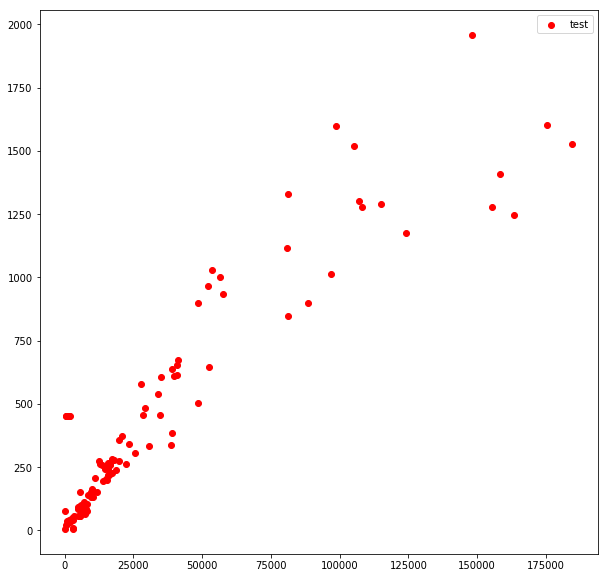

In [33]:
%matplotlib inline
plt.figure(figsize=(10,10))
#plt.scatter(df_train_bd1['gas_prod'], 
#           df_train_bd1['oil_prod'], color = 'g', label='train')
plt.scatter(df_test_bd1[df_test_bd1['oil_prod']>0]['gas_prod'], 
            df_test_bd1[df_test_bd1['oil_prod']>0]['oil_prod'], color = 'r', label='test')
plt.legend()

### Далее идет подготовка данных и модели для ряда
Сдвигаем oil_rate на одиг шаг (столбец oil_rate_1) и прогнозируем его

In [34]:
df_train_time_bd1 = df_all_train[(df_all_train['Скважина'].isin(wells_bd1_train))]

df_train_time_bd1['oil_rate_1'] = np.concatenate((df_train_time_bd1['oil_rate'].values.reshape(-1,1)[1:,:], np.zeros((1,1))), axis = 0)
#df_train_time_bd1.iloc[:-1,-1] = df_train_time_bd1.iloc[1:,3]

df_train_time_bd1 = df_train_time_bd1[df_train_time_bd1['month'] != 5]

df_train_time_bd1.loc[:, 'clust'] = (df_train_time_bd1[['Скважина', 'frac']].set_index('Скважина'). \
            join(df_train_bd1[['Скважина', 'clust']].set_index('Скважина')))['clust'].values

df_train_time_bd1 = df_train_time_bd1.dropna(subset=['clust'])

df_train_time_bd1['clust'] = df_train_time_bd1['clust'].astype('int8')

df_train_time_bd1.loc[:, 'Давление пластовое'] = df_train_time_bd1.loc[:, 'Давление пластовое'].fillna(df_train_time_bd1.loc[:, 'Давление пластовое'].mean())

df_train_time_bd1.loc[df_train_time_bd1['Давление пластовое'] == 0 , 'Давление пластовое'] = df_train_time_bd1.loc[df_train_time_bd1['Давление пластовое'] != 0 , 'Давление пластовое'].mean()

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
df_train_time_bd1

,Скважина,Дата,liq_rate,oil_rate,wct,gas_rate,gf,gas_prod,days_on,oil_prod,frac,month,Давление пластовое,ПЛАСТ_X,ПЛАСТ_Y,clust,num_of_pr,num_of_plast,oil_rate_1
0,005642f48d3e86d871bb701bac2ba042,2005-06-01,29.777778,29.722222,0.001866,1642.666667,64.000000,29568.0,18.000000,462.00,1,0,103.150000,NaN,NaN,1,2.0,NaN,6.290323
1,005642f48d3e86d871bb701bac2ba042,2005-07-01,6.290323,6.290323,0.000000,350.967742,64.000000,10880.0,31.000000,170.00,1,1,103.150000,NaN,NaN,1,2.0,NaN,5.366667
2,005642f48d3e86d871bb701bac2ba042,2005-08-01,5.366667,5.366667,0.000000,298.666667,64.000000,8960.0,30.000000,140.00,1,2,103.150000,NaN,NaN,1,2.0,NaN,5.500000
3,005642f48d3e86d871bb701bac2ba042,2005-09-01,5.500000,5.500000,0.000000,305.230769,64.000000,7936.0,26.000000,124.00,1,3,103.150000,NaN,NaN,1,2.0,NaN,9.733333
4,005642f48d3e86d871bb701bac2ba042,2005-10-01,9.733333,9.733333,0.000000,541.866667,64.000000,16256.0,30.000000,254.00,1,4,103.150000,NaN,NaN,1,2.0,NaN,47.064516
6,02384c4d1324238fb99fcf66c88fbdad,2011-03-01,41.020408,32.204082,0.214925,1941.122449,69.224891,31705.0,16.333333,458.00,1,0,218.566667,NaN,NaN,2,3.0,NaN,36.354839
7,02384c4d1324238fb99fcf66c88fbdad,2011-04-01,54.612903,36.354839,0.334318,2603.709677,82.278287,80715.0,31.000000,981.00,1,1,218.566667,NaN,NaN,2,3.0,NaN,29.000000
8,02384c4d1324238fb99fcf66c88fbdad,2011-05-01,46.900000,29.000000,0.381663,1987.366667,78.759577,59621.0,30.000000,757.00,1,2,218.566667,NaN,NaN,2,3.0,NaN,27.064516
9,02384c4d1324238fb99fcf66c88fbdad,2011-06-01,47.064516,27.064516,0.424949,1943.258065,82.521918,60241.0,31.000000,730.00,1,3,218.566667,NaN,NaN,2,3.0,NaN,23.714194
10,02384c4d1324238fb99fcf66c88fbdad,2011-07-01,33.359677,23.714194,0.289136,1681.096774,81.482871,52114.0,31.000000,639.57,1,4,218.566667,NaN,NaN,2,3.0,NaN,23.714194


In [35]:
X_time_bd1 = df_train_time_bd1[['oil_rate', 'frac', 'month', 'clust', 'Давление пластовое']]
y_time_bd1 = df_train_time_bd1['oil_rate_1']

In [36]:
xgb_reg_time = xgb.XGBRegressor()
cross_validate(xgb_reg_time, X_time_bd1, y_time_bd1, scoring='neg_mean_absolute_error')

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.077, 0.064, 0.059]),
 'score_time': array([0.003, 0.003, 0.003]),
 'test_score': array([-4.859, -5.152, -5.504]),
 'train_score': array([-4.339, -4.161, -4.19 ])}

In [39]:
cat_f_ind_time = np.where(X_time_bd1.dtypes != np.float)[0]
cv_params={
    'eval_metric': 'MAE',
    'verbose':False
}

In [39]:
cat_f_ind_time = np.where(X_time_bd1.dtypes != np.float)[0]
cv_params={
    'eval_metric': 'MAE',
    'verbose':False
}

In [38]:
xgb_reg_time.fit(X_time_bd1, y_time_bd1)
feature_importances = xgb_reg_time.feature_importances_
feature_names = X_time_bd1.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score*100))

oil_rate: 66.93944334983826
Давление пластовое: 17.348608374595642
month: 7.8559741377830505
clust: 6.21931254863739
frac: 1.6366612166166306


In [ ]:
cv_data = cчv(
    Pool(X_time_bd1, y_time_bd1, cat_features=cat_f_ind_time),
    cv_params,
    plot=True
)

### Катбуст дает очень странный сильный приоритет фраку!!! ???

In [40]:
train_pool_time = Pool(X_time_bd1, y_time_bd1, cat_features=cat_f_ind_time)
cbr_time_bd1 = CatBoostRegressor(verbose=False, cat_features=cat_f_ind_time)
cbr_time_bd1.fit(train_pool_time)
feature_importances = cbr_bd1.get_feature_importance(train_pool_time)
feature_names = X_time_bd1.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

frac: 74.0078564126875
month: 9.259156065436517
Давление пластовое: 8.067228553332596
oil_rate: 4.7993555266919925
clust: 2.297654950458348


In [41]:
y_time_bd1_pred_cb = cbr_time_bd1.predict(X_time_bd1)
y_time_bd1_pred_xgb = xgb_reg_time.predict(X_time_bd1)

### Использую в итоге xgb, хотя можно еще что нибудь обучить и стакнуть, но я это плохо делаю

In [42]:
df_train_time_bd1['oil_pred'] = y_time_bd1_pred_xgb

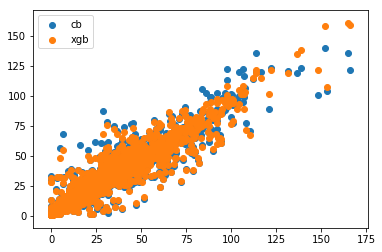

In [43]:
#df_train_time_bd1.plot.scatter(x = 'oil_rate_1', y = 'oil_pred')
plt.scatter(df_train_time_bd1['oil_rate_1'], y_time_bd1_pred_cb, label = 'cb')
plt.scatter(df_train_time_bd1['oil_rate_1'], y_time_bd1_pred_xgb, label = 'xgb')
plt.legend()

In [44]:
df_test_bd1['oil_rate'] = df_test_bd1['oil_prod']/df_test_bd1['days_on']
df_test_bd1['month'] = 0

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
df_test_time_bd1 = df_test_bd1.copy()

df_test_time_bd1['month'] = 0

### Делаем прогноз итеративно на месяц

In [46]:
df_y_time_pred = df_test_time_bd1[['Скважина', 'month', 'oil_rate']].set_index(['Скважина', 'month']).unstack(0)
y_test_time_bd1 = df_test_time_bd1['oil_rate'].values
for i in range(0,5):
    
    X_test_time_bd1 = pd.concat((
                            pd.DataFrame(y_test_time_bd1, index = df_test_time_bd1['Скважина'], columns = ['oil_rate']),
                            df_test_time_bd1[['Скважина', 'frac', 'month', 'clust', 'Давление пластовое']].set_index('Скважина')
                        ), axis = 1)
    X_test_time_bd1['month'] = i
    y_test_time_bd1 = xgb_reg_time.predict(X_test_time_bd1)
    
    df_y_test_pred = pd.DataFrame(y_test_time_bd1, index = df_test_time_bd1['Скважина'], columns = ['oil_rate'])

    df_y_test_pred['month'] = i+1

    df_y_test_pred = df_y_test_pred.reset_index()


    df_y_time_pred = pd.concat((
                                df_y_time_pred,
                                df_y_test_pred.set_index(['Скважина', 'month']).unstack(0)
                         ), axis = 0)

### Смотрим как выглядит статистика

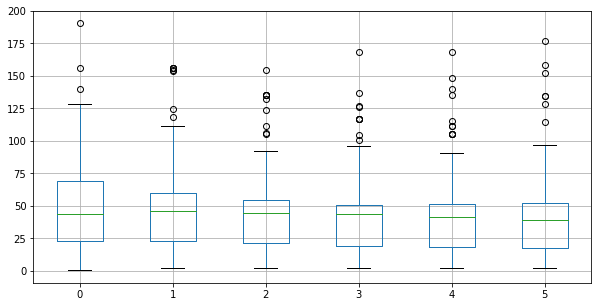

In [47]:
%matplotlib inline
plt.figure(figsize=(10,5))

df_y_time_pred[df_y_time_pred < 200].T.boxplot()
#df_y_time_pred.T.boxplot()


### Считаем среднее количество дней, которые скважины работает

In [49]:
df_days_train = df_all_train[['Скважина','month', 'days_on']].set_index(['Скважина', 'month']).unstack(0).fillna(0)
df_days_train.columns = df_days_train.columns.droplevel(0)
mean_days_on = df_days_train.mean(axis = 1).values
median_days_on = df_days_train.median(axis = 1).values

### Переводим дебит в добычу (здесь изначально добыча была в тоннах, поэтому не надо делить на плотность)

In [50]:
df_y_time_pred_prod = pd.DataFrame(df_y_time_pred.values * median_days_on.reshape(-1,1),
                                   index = df_y_time_pred.index,
                                   columns = df_y_time_pred.columns
                                  )

df_y_time_pred_prod.loc[0] = df_test_time_bd1[['Скважина', 'oil_prod']].set_index('Скважина')['oil_prod'].values

In [51]:
df_pred = df_y_time_pred.stack().swaplevel().join(df_test_bd1[['Скважина', 'month', 'oil_prod', 'days_on']].set_index(['Скважина', 'month']))#.reset_index().set_index('Скважина')

#df_pred['oil_prod_pred'] = 0.0

#df_pred.loc[df_pred['month'] == 0, 'oil_prod_pred'] = df_test_bd1['oil_prod'].set_index('Скважина')

### Целевой столбец 'oil_prod'

In [52]:
df_pred

,,oil_rate,oil_prod,days_on
Скважина,month,,,
01ba18d8b6d29875a18d4bca4eb201d7,0,22.677866,113.389328,5.000000
0254a227c6c2c31a419126700cfcddc2,0,18.053317,145.178757,8.041667
05f25fce2aed2f110809dc26927306a8,0,55.420693,609.627625,11.000000
063ef812d50c7c6d8d3ab8ed20a1523e,0,90.133889,1029.028564,11.416667
08831558b0cdd64d894ff489e0277401,0,22.649149,258.577789,11.416667
09ffe420dd956d5fc9395ccbad14d01d,0,28.252920,254.276276,9.000000
0e12befb401e4a3a92f6db3a97f4afb7,0,57.578756,1012.426453,17.583333
0f7604f319a5f568b77d4781033d314d,0,19.563741,262.480194,13.416667
117e57bb0d7db299662e2d02928edd96,0,5.005586,150.167572,30.000000
